In [ ]:
# Install kagglehub (usually preinstalled, but safe)
!pip install kagglehub


In [ ]:
import pandas as pd
import numpy as np
import re
import os

import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
print("Downloading dataset...")

path = kagglehub.dataset_download("kazanova/sentiment140")

csv_path = os.path.join(
    path,
    "training.1600000.processed.noemoticon.csv"
)

print("Loading CSV...")

df = pd.read_csv(
    csv_path,
    encoding="latin-1",
    header=None,
    names=['sentiment', 'id', 'date', 'query', 'user', 'text']
)

print("Total rows:", len(df))
df.head()


Using Colab cache for faster access to the 'sentiment140' dataset.
Loading CSV...
Total rows: 1600000


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# Convert labels: 0 = Negative, 4 = Positive
df['sentiment'] = df['sentiment'].replace({0: 0, 4: 1})

print(df['sentiment'].value_counts())


sentiment
0    800000
1    800000
Name: count, dtype: int64


In [ ]:
df_neg = df[df['sentiment'] == 0].sample(200000, random_state=42)
df_pos = df[df['sentiment'] == 1].sample(200000, random_state=42)

df = pd.concat([df_neg, df_pos]).sample(frac=1, random_state=42).reset_index(drop=True)

print(df['sentiment'].value_counts())


sentiment
0    200000
1    200000
Name: count, dtype: int64


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [ ]:
print("Cleaning text...")
df['clean_text'] = df['text'].apply(clean_text)
print("Done!")
df[['text', 'clean_text']].head()


Cleaning text...
Done!


,text,clean_text
0,would like to settle down and watch the footba...,would like settle watch football beer fat bloo...
1,reaalllly hungry. want pho. and/or fried chick...,reaalllly hungry want pho andor fried chicken ...
2,@fiftypavements they don't air here so I have ...,dont air watch youtube
3,is waiting for Kristin's call.... need to go o...,waiting kristins call need go theyre driving n...
4,"Susan Boyle(Bwaakk), Google Wave, BGT, Diversi...",susan boylebwaakk google wave bgt diversity la...


In [ ]:
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train labels:")
print(y_train.value_counts())


Train labels:
sentiment
1    160000
0    160000
Name: count, dtype: int64


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2)
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

X_train_tfidf.shape


(320000, 5000)

In [ ]:
lr = LogisticRegression(max_iter=1000)
nb = MultinomialNB()
svm = LinearSVC()

lr.fit(X_train_tfidf, y_train)
nb.fit(X_train_tfidf, y_train)
svm.fit(X_train_tfidf, y_train)

print("Models trained successfully!")


Models trained successfully!


In [ ]:
models = {
    "Logistic Regression": lr,
    "Naive Bayes": nb,
    "SVM": svm
}

for name, model in models.items():
    print(f"\n{name}")
    y_pred = model.predict(X_test_tfidf)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))



Logistic Regression
Accuracy: 0.7721375
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     40000
           1       0.76      0.79      0.78     40000

    accuracy                           0.77     80000
   macro avg       0.77      0.77      0.77     80000
weighted avg       0.77      0.77      0.77     80000


Naive Bayes
Accuracy: 0.7570125
              precision    recall  f1-score   support

           0       0.75      0.76      0.76     40000
           1       0.76      0.75      0.76     40000

    accuracy                           0.76     80000
   macro avg       0.76      0.76      0.76     80000
weighted avg       0.76      0.76      0.76     80000


SVM
Accuracy: 0.77085
              precision    recall  f1-score   support

           0       0.79      0.74      0.76     40000
           1       0.76      0.80      0.78     40000

    accuracy                           0.77     80000
   macro avg       0.77      0.

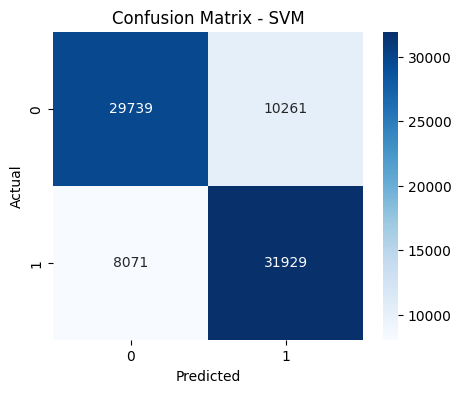

In [ ]:
y_pred = svm.predict(X_test_tfidf)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM")
plt.show()


In [ ]:
def predict_sentiment(text):
    text = clean_text(text)
    vec = vectorizer.transform([text])
    pred = svm.predict(vec)[0]
    return "Positive" if pred == 1 else "Negative"


In [ ]:
predict_sentiment("I absolutely love this product!")


'Positive'